# Import Library

In [1]:
import os
from google.colab import files

import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import ImageFile

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.metrics import confusion_matrix, classification_report


# Connect to Kaggle API

In [2]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Download datasets

In [3]:
! kaggle datasets download -d kaustubhb999/tomatoleaf -p /content/images/ --unzip

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
100% 178M/179M [00:09<00:00, 22.2MB/s]
100% 179M/179M [00:09<00:00, 20.3MB/s]


# Make Dataframe

In [4]:
# Define paths for images and their respective classes
def define_paths(dir):
    files_path = []
    classes = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        file_list = os.listdir(folder_path)
        for file_name in file_list:
            fpath = os.path.join(folder_path, file_name)
            files_path.append(fpath)
            classes.append(folder)
    return files_path, classes

# Create a dataframe from file paths and classes
def define_df(files, classes):
    file_series = pd.Series(files, name= 'file_paths')
    class_series = pd.Series(classes, name='class')
    return pd.concat([file_series, class_series], axis= 1)

# Generate dataframe for a given directory
def make_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [5]:
# Define directories for training and validation data
train_dir = '/content/images/tomato/train'
valid_dir = '/content/images/tomato/val'

temp_df = make_df(train_dir)
test_df = make_df(valid_dir)

train_df, valid_df = train_test_split(temp_df, train_size=0.9, shuffle=True, random_state=42, stratify=temp_df['class'])

In [6]:
print(train_df['class'].value_counts())

class
Tomato___Tomato_mosaic_virus                     900
Tomato___Late_blight                             900
Tomato___Tomato_Yellow_Leaf_Curl_Virus           900
Tomato___healthy                                 900
Tomato___Septoria_leaf_spot                      900
Tomato___Bacterial_spot                          900
Tomato___Leaf_Mold                               900
Tomato___Target_Spot                             900
Tomato___Early_blight                            900
Tomato___Spider_mites Two-spotted_spider_mite    900
Name: count, dtype: int64


In [7]:
print(train_df.groupby(['class']).count())
print('Train set minimum class count : ', train_df.groupby(['class']).count().min())
print(valid_df.groupby(['class']).count())
print('Validation set minimum class count:', valid_df.groupby(['class']).count().min())
print(test_df.groupby(['class']).count())
print('Test set minimum class count:', test_df.groupby(['class']).count().min())

                                               file_paths
class                                                    
Tomato___Bacterial_spot                               900
Tomato___Early_blight                                 900
Tomato___Late_blight                                  900
Tomato___Leaf_Mold                                    900
Tomato___Septoria_leaf_spot                           900
Tomato___Spider_mites Two-spotted_spider_mite         900
Tomato___Target_Spot                                  900
Tomato___Tomato_Yellow_Leaf_Curl_Virus                900
Tomato___Tomato_mosaic_virus                          900
Tomato___healthy                                      900
Train set minimum class count :  file_paths    900
dtype: int64
                                               file_paths
class                                                    
Tomato___Bacterial_spot                               100
Tomato___Early_blight                                 100
Tomato__

# Image data generator

In [8]:
img_size = (224, 224)
batch = 40
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

# Data augmentation for training data
tr_datagen = ImageDataGenerator(
     rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
    )

# Data generator for validation and test data
ts_and_vl_datagen = ImageDataGenerator(rescale=1./255)

print('For train')
train_generator = tr_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    class_mode='categorical')

print('\nFor validation')
validation_generator = ts_and_vl_datagen.flow_from_dataframe(
    valid_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=False,
    class_mode='categorical')

print('\nFor test')
test_generator = ts_and_vl_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch,
    shuffle=False,
    class_mode='categorical')



For train
Found 9000 validated image filenames belonging to 10 classes.

For validation
Found 1000 validated image filenames belonging to 10 classes.

For test
Found 1000 validated image filenames belonging to 10 classes.


We use `test_batch = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))` so that we will go through all the sample in the test dataset exactly once.

# Plot Image Sample

In [9]:
def show_sample_images(generator, num_sample=30):
    class_list = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize= (25, 15))
    length = len(labels)
    sample = min(length, 30)
    for i in range(sample):
        plt.subplot(5, 6, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name, color= 'green', fontsize= 14)
        plt.axis('off')
    plt.show()

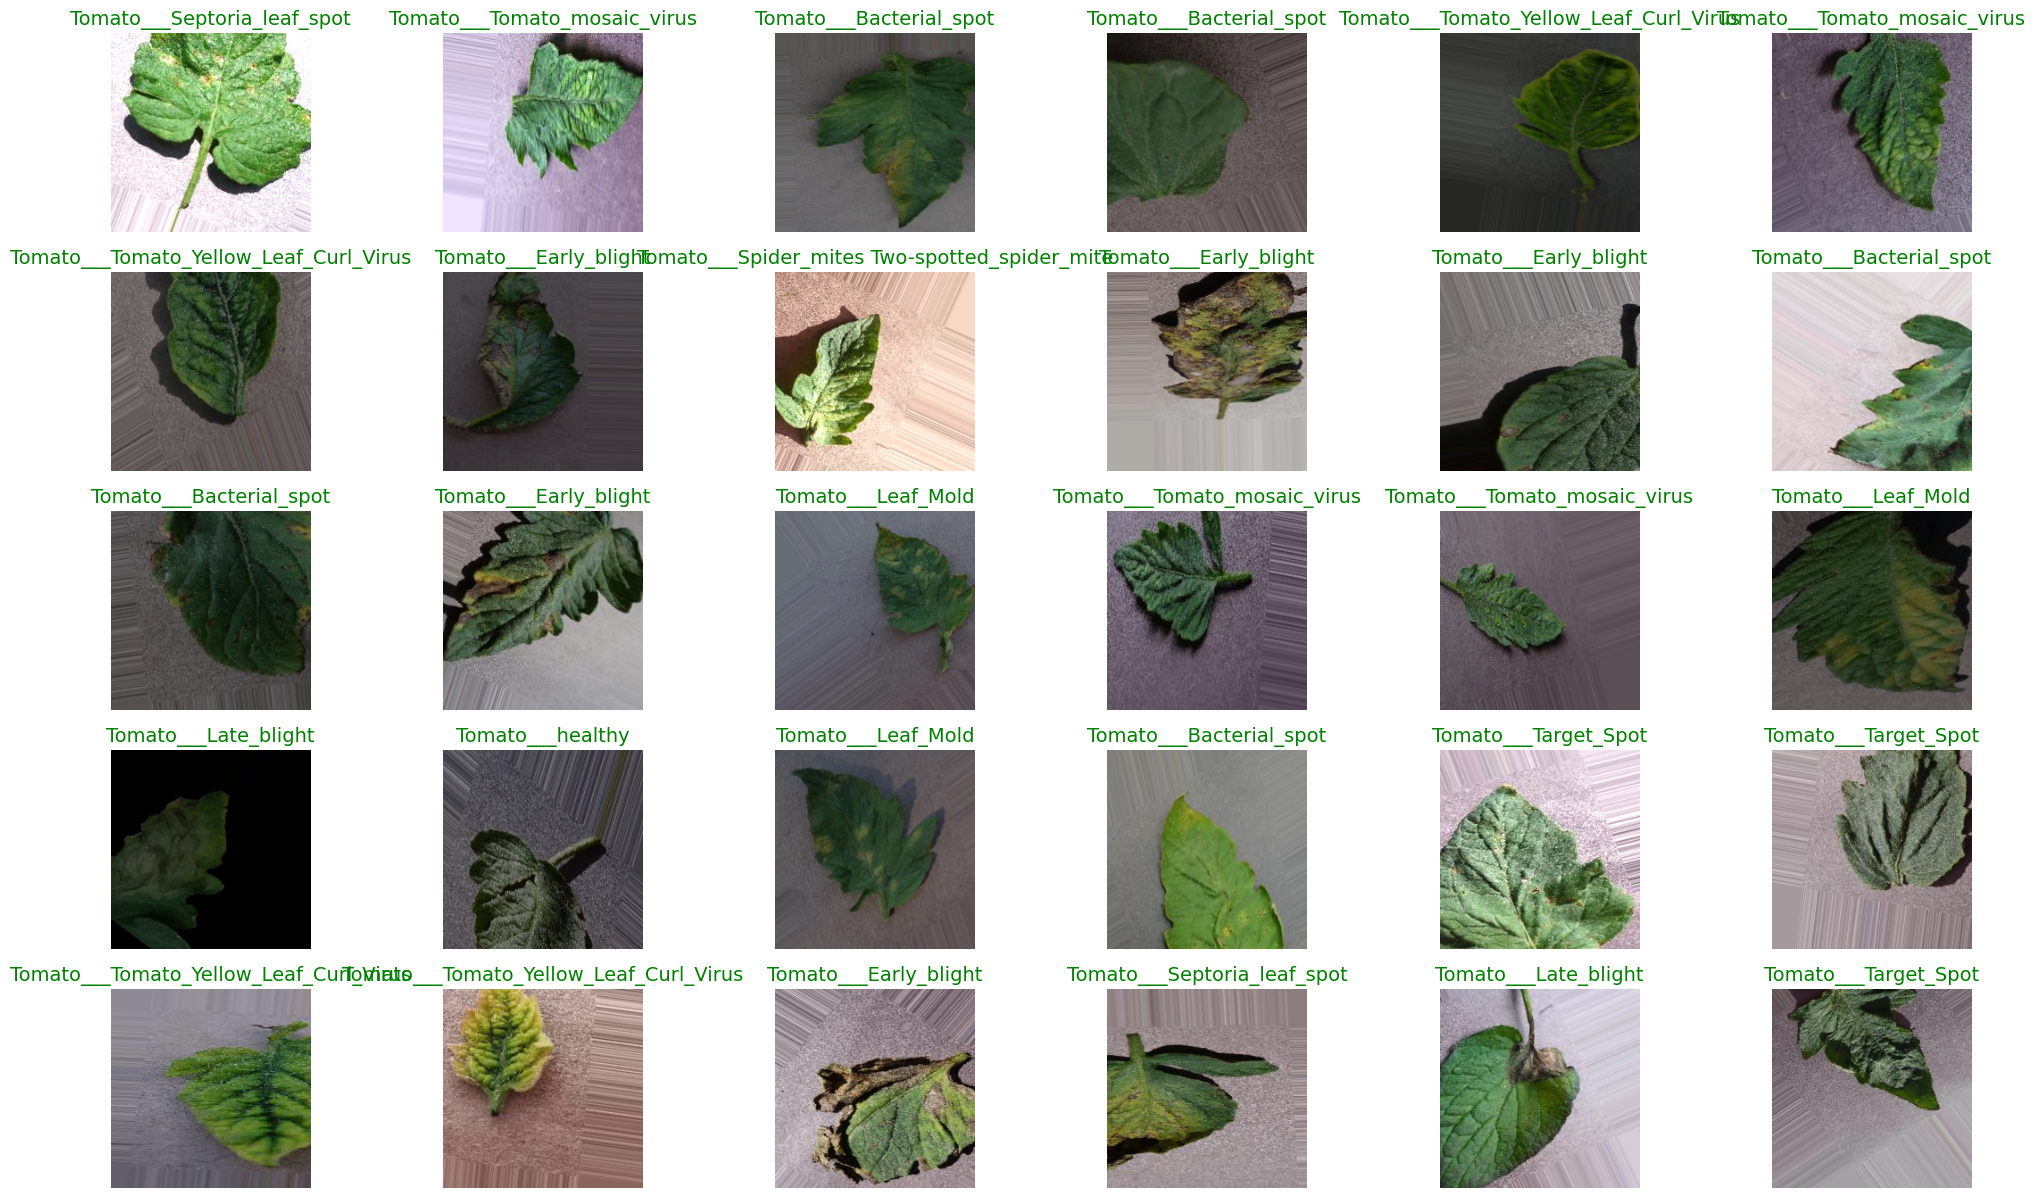

In [10]:
show_sample_images(train_generator)

# Create Model

In [11]:

from tensorflow.keras.layers import BatchNormalization

def create_model(transfer_model):
    img_shape = (224, 224, 3)
    class_num = len(list(train_generator.class_indices.keys()))
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)

    base_model.trainable = True
    for layer in base_model.layers[:-20]:  #you can change the number of layers to be frozen
      layer.trainable = False

    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
    BatchNormalization(),
    Dropout(rate=0.3), 
    Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
    Dropout(rate=0.3), 
    Dense(class_num, activation='softmax')
])

    return model


## MobileNetV2 Model

In [12]:
from tensorflow.keras.optimizers import Adam

mobilenet = create_model("MobileNetV2") # you can change the model to DenseNet201, Xception, or VGG16
optimizer = Adam(learning_rate=1e-4)
mobilenet.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics= ['accuracy'])

mobilenet.summary()
mobilenet.layers[0].summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,049,802 (11.63 MB)

 Trainable params: 1,996,874 (7.62 MB)

 Non-trainable params: 1,052,928 (4.02 MB)

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,206,080 (4.60 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

# Custom Callback

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached 97%!")
            self.model.stop_training = True

my_callbacks = MyCallback()

# Train Model

Run code below so that no truncated images error while train the models

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## MobileNetV2 Training

In [15]:
initial_epochs = 30

history_mobilenet = mobilenet.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=initial_epochs,
    verbose=2,
    callbacks=[my_callbacks, reduce_lr, early_stopping],  
    validation_steps=None,
    shuffle=False,
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 - 711s - 3s/step - accuracy: 0.6744 - loss: 7.2017 - val_accuracy: 0.4140 - val_loss: 8.3630 - learning_rate: 0.0010
Epoch 2/30
225/225 - 685s - 3s/step - accuracy: 0.8014 - loss: 2.0433 - val_accuracy: 0.5660 - val_loss: 3.3653 - learning_rate: 0.0010
Epoch 3/30
225/225 - 680s - 3s/step - accuracy: 0.8407 - loss: 0.9373 - val_accuracy: 0.2770 - val_loss: 7.9711 - learning_rate: 0.0010
Epoch 4/30
225/225 - 682s - 3s/step - accuracy: 0.8508 - loss: 0.7035 - val_accuracy: 0.5460 - val_loss: 2.7712 - learning_rate: 0.0010
Epoch 5/30
225/225 - 688s - 3s/step - accuracy: 0.8632 - loss: 0.6264 - val_accuracy: 0.5520 - val_loss: 2.5635 - learning_rate: 0.0010
Epoch 6/30
225/225 - 723s - 3s/step - accuracy: 0.8718 - loss: 0.5950 - val_accuracy: 0.4720 - val_loss: 3.6229 - learning_rate: 0.0010
Epoch 7/30
225/225 - 704s - 3s/step - accuracy: 0.8722 - loss: 0.5815 - val_accuracy: 0.6930 - val_loss: 1.4738 - learning_rate: 0.0010
Epoch 8/30
225/225 - 684s - 3s/step - accuracy: 0.8776 - lo

# Plot Model Training

In [16]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

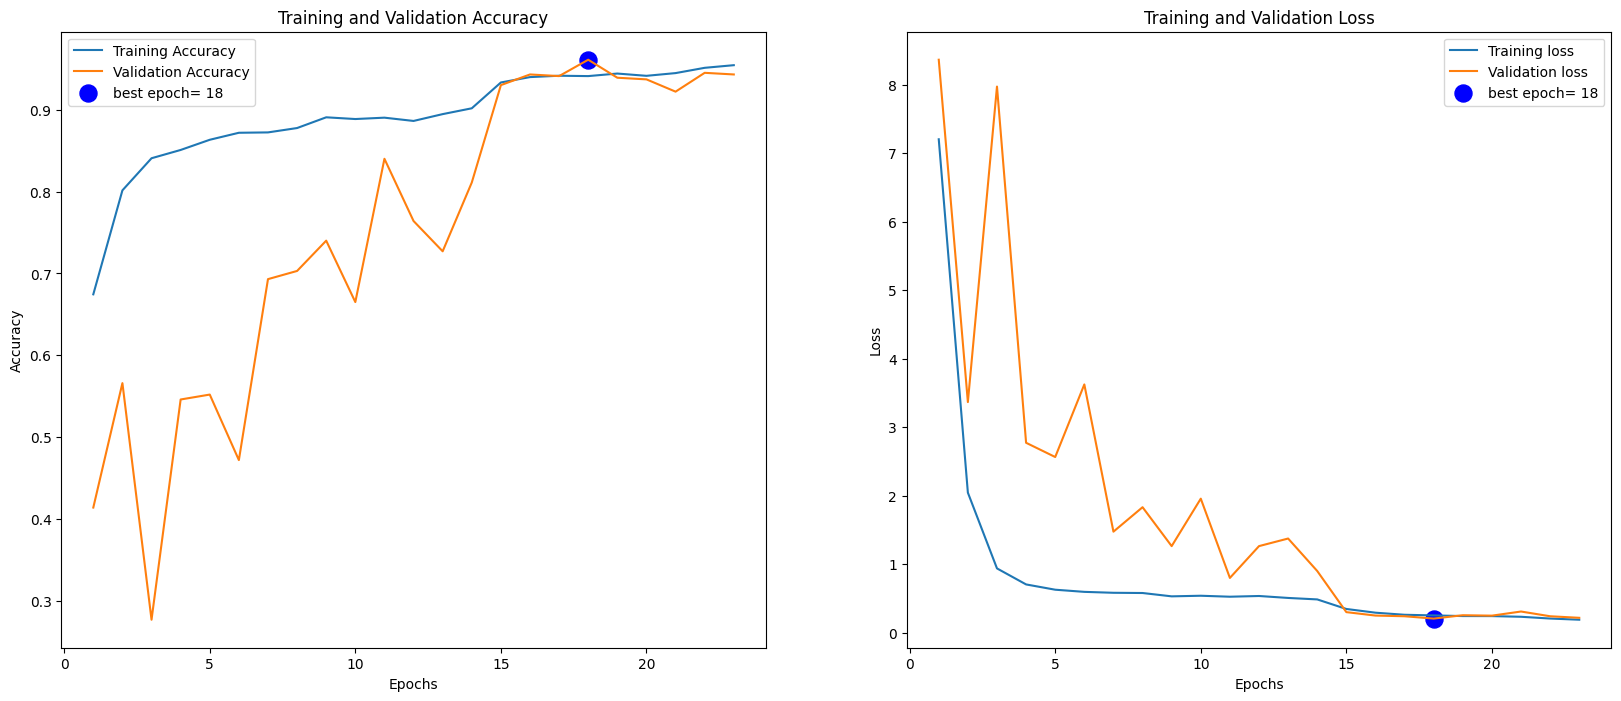

In [17]:
plot_training(history_mobilenet)

# Fine Tuning

## MobileNetV2

In [18]:
# Unfreeze all layers
mobilenet.layers[0].trainable = True
mobilenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,043,552 (26.87 MB)

 Trainable params: 1,996,874 (7.62 MB)

 Non-trainable params: 1,052,928 (4.02 MB)

 Optimizer params: 3,993,750 (15.23 MB)

In [19]:
mobilenet.compile(
    optimizer=Adam(1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [20]:
fine_tune_epoch = 20
total_epochs =  initial_epochs + fine_tune_epoch

history_mobilenet_fine = mobilenet.fit(x=train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_mobilenet.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[my_callbacks])

Epoch 23/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 667s 3s/step - accuracy: 0.9444 - loss: 0.2387 - val_accuracy: 0.9610 - val_loss: 0.1921
Epoch 24/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 666s 3s/step - accuracy: 0.9520 - loss: 0.2160 - val_accuracy: 0.9590 - val_loss: 0.1872
Epoch 25/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.9547 - loss: 0.2099 - val_accuracy: 0.9600 - val_loss: 0.1832
Epoch 26/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.9525 - loss: 0.2004 - val_accuracy: 0.9620 - val_loss: 0.1778
Epoch 27/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - accuracy: 0.9549 - loss: 0.1971 - val_accuracy: 0.9580 - val_loss: 0.1800
Epoch 28/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.9518 - loss: 0.1996 - val_accuracy: 0.9580 - val_loss: 0.1828
Epoch 29/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.9524 - loss: 0.2043 - val_accuracy: 0.9560 - val_loss: 0.1823
Epoch 30/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.9572 - loss: 0.1808 - 

# Plot model before and after fine tuning

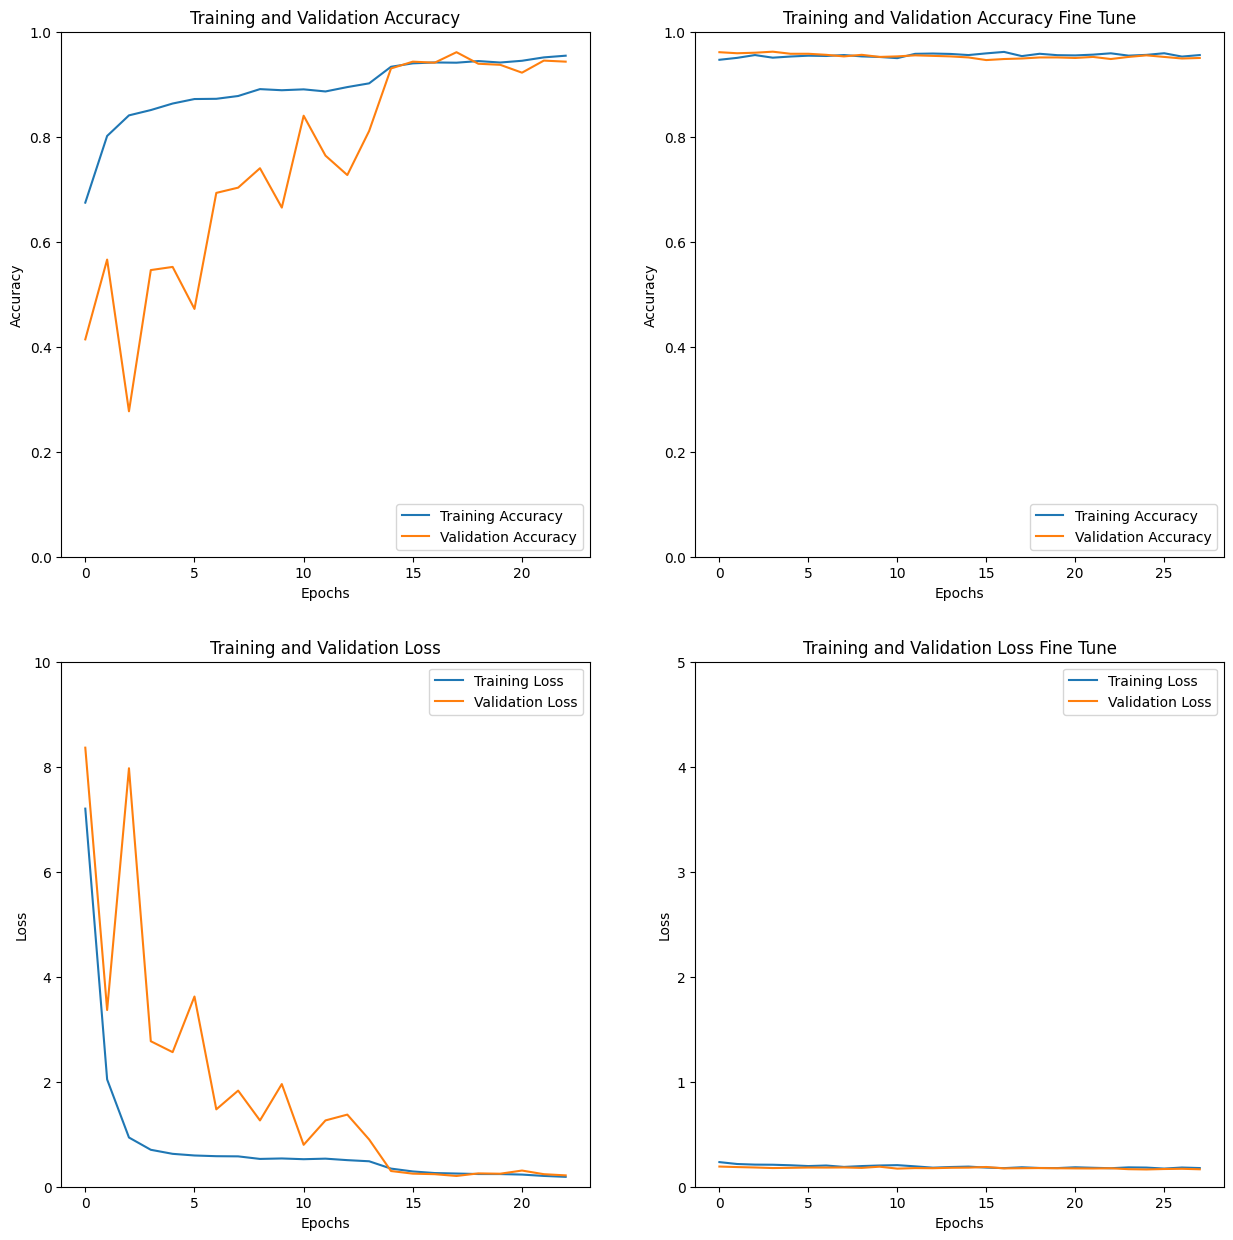

In [33]:
plt.figure(figsize= (15, 15))

plt.subplot(2, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history_mobilenet_fine.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet_fine.history['val_accuracy'], label= 'Validation Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy Fine Tune')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history_mobilenet.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 10.0])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')


plt.subplot(2, 2, 4)
plt.plot(history_mobilenet_fine.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet_fine.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 5.0])
plt.title('Training and Validation Loss Fine Tune')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout
plt.show()

# Evaluate model

In [22]:
ts_length = len(test_df)
steps = ts_length // test_batch
train_score = mobilenet.evaluate(train_generator, steps=steps, verbose= 1)
valid_score = mobilenet.evaluate(validation_generator, steps=steps, verbose= 1)
test_score = mobilenet.evaluate(test_generator, steps=steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9722 - loss: 0.1207
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9565 - loss: 0.1514
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9493 - loss: 0.1690
Train Loss:  0.12402068078517914
Train Accuracy:  0.9712499976158142
--------------------
Validation Loss:  0.16439099609851837
Validation Accuracy:  0.949999988079071
--------------------
Test Loss:  0.173039510846138
Test Accuracy:  0.9520000219345093


# Prediction

In [23]:
preds = mobilenet.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]
print(y_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 

# Evaluation

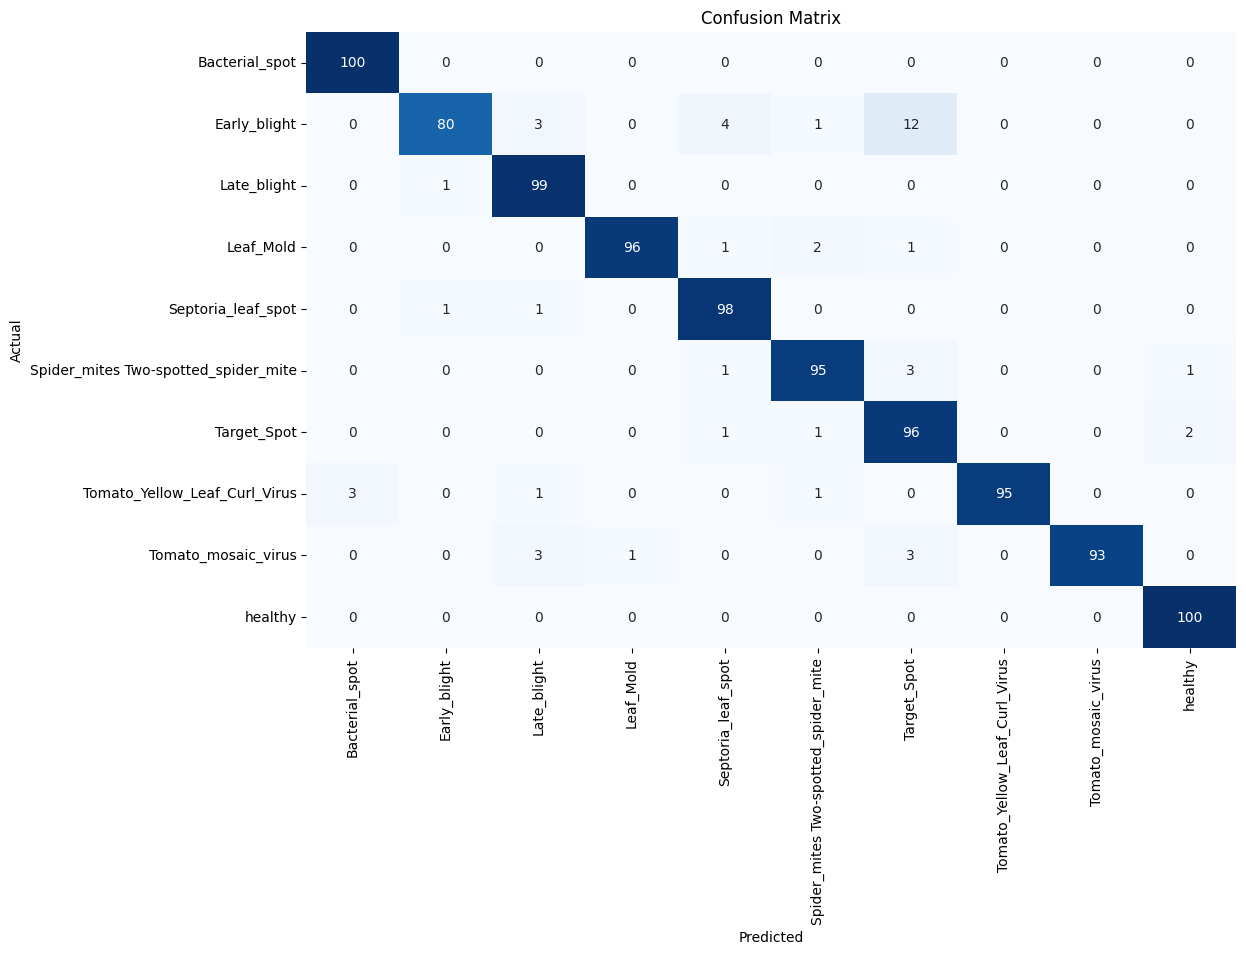


Classification Report:
----------------------
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.97      1.00      0.99       100
                        Early_blight       0.98      0.80      0.88       100
                         Late_blight       0.93      0.99      0.96       100
                           Leaf_Mold       0.99      0.96      0.97       100
                  Septoria_leaf_spot       0.93      0.98      0.96       100
Spider_mites Two-spotted_spider_mite       0.95      0.95      0.95       100
                         Target_Spot       0.83      0.96      0.89       100
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.95      0.97       100
                 Tomato_mosaic_virus       1.00      0.93      0.96       100
                             healthy       0.97      1.00      0.99       100

                            accuracy                           0.95      1000
               

In [24]:
def make_evaluation(test_gen, y_pred):
  classes = [label[9:] for label in list(test_gen.class_indices.keys())] # slice word "Tomato___"
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(test_generator.classes, y_pred, target_names=classes))


make_evaluation(test_generator, y_pred)

# Save Model

# saved_model

In [25]:
save_path = 'saved_model/'
tf.saved_model.save(mobilenet, save_path)

In [26]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 92%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 77%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 9%)


## HDF5 Model

In [27]:
mobilenet.save("model.h5")

## ONNX Model

In [34]:

!pip install --upgrade pip
!pip install onnxruntime
!pip install -U tf2onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [35]:
!python -m tf2onnx.convert --saved-model "saved_model" --output "model.onnx" --extra_opset ai.onnx.contrib:1

2025-01-17 09:45:22.607152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 09:45:22.631852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 09:45:22.638939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 09:45:24.428316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-17 09:45:27,079 - WARNING - tensorf

## Pickle Model

In [36]:
import pickle

pickle.dump(mobilenet, open('model.pkl', 'wb'))